In [1]:
import os

import torch

from src.ddpg import DDPGActor, DDPGCritic, DDPGPolicy, DDPGAgent
from src.pv_env import History, PVEnv
from src.reward import RewardDeltaPower

PV_PARAMS_PATH = os.path.join("parameters", "01_pvarray.json")
WEATHER_TRAIN_PATH = os.path.join("data", "weather_sim.csv")
WEATHER_TEST_PATH = os.path.join("data", "weather_real.csv")
PVARRAY_CKP_PATH = os.path.join('data', '01_pvarray_iv.json')
AGENT_CKP_PATH = os.path.join("models", "02_mppt_ac.tar")
LEARNING_RATE = 0.00001
ENTROPY_BETA = 0.001
GAMMA = 0.9
N_STEPS = 4
BATCH_SIZE = 16

In [2]:
env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(1, 0.9),
)
test_env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(1, 0.9),
)
device = torch.device("cpu")
act_net = DDPGActor(
    env.observation_space.shape[0],
    env.action_space.shape[0]
).to(device)
crt_net = DDPGCritic(
    env.observation_space.shape[0],
    env.action_space.shape[0]
).to(device)
agent = DDPGAgent(
    env=env,
    test_env=test_env,
    act_net=act_net,
    crt_net=crt_net,
    device=device,
    gamma=GAMMA,
    beta_entropy=ENTROPY_BETA,
    lr=LEARNING_RATE,
    n_steps=N_STEPS,
    batch_size=BATCH_SIZE,
    # chk_path=AGENT_CKP_PATH,
    chk_path=None,
)

INFO 2020-11-21 21:52:07,447 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-21 21:52:07,448 Starting MATLAB engine . . .
INFO 2020-11-21 21:52:12,490 MATLAB engine initializated.
INFO 2020-11-21 21:52:34,109 Model loaded succesfully.
INFO 2020-11-21 21:52:34,132 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-21 21:52:34,135 Reading data\weather_sim.csv . . .
INFO 2020-11-21 21:52:34,149 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-21 21:52:34,150 Starting MATLAB engine . . .
INFO 2020-11-21 21:52:39,915 MATLAB engine initializated.
INFO 2020-11-21 21:53:01,697 Model loaded succesfully.
INFO 2020-11-21 21:53:01,728 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-21 21:53:01,731 Reading data\weather_sim.csv . . .


In [3]:
env.action_space

Box(-16.450000762939453, 16.450000762939453, (1,), float32)

In [11]:
agent.learn(steps=100000, verbose_every=10000, save_every=0)

 10%|█         | 10020/100000 [01:24<12:42, 117.94it/s]
 30000: loss=2918.590504,  mean reward=-1770.54,  steps/ep=833,  episodes=142
 20%|██        | 20022/100000 [02:49<11:21, 117.37it/s]
 40000: loss=919.037953,  mean reward=-1746.40,  steps/ep=833,  episodes=190
 30%|███       | 30016/100000 [04:14<09:53, 117.87it/s]
 50000: loss=2581.511950,  mean reward=-1753.42,  steps/ep=833,  episodes=238
 40%|████      | 40013/100000 [05:40<08:42, 114.82it/s]
 60000: loss=536.573979,  mean reward=-1758.56,  steps/ep=833,  episodes=286
 50%|█████     | 50010/100000 [07:05<07:09, 116.45it/s]
 70000: loss=1059.801508,  mean reward=-1762.71,  steps/ep=833,  episodes=334
 60%|██████    | 60010/100000 [08:31<05:46, 115.37it/s]
 80000: loss=356.043390,  mean reward=-1743.16,  steps/ep=833,  episodes=381
 70%|███████   | 70011/100000 [09:57<04:13, 118.33it/s]
 90000: loss=472.216101,  mean reward=-1738.68,  steps/ep=833,  episodes=429
 80%|████████  | 80019/100000 [11:21<02:48, 118.55it/s]
 100000: l

INFO 2020-11-21 21:54:35,891 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 765.08it/s]
INFO 2020-11-21 21:54:36,985 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 208552.41it/s]


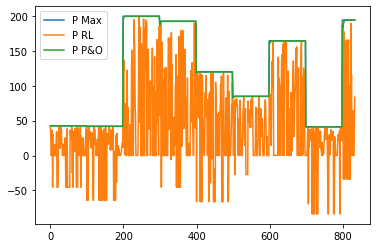

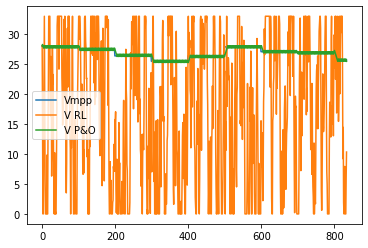

INFO 2020-11-21 21:54:37,706 PO Efficiency=99.87892064901877
INFO 2020-11-21 21:54:37,707 RL Efficiency=25.681400670375524


In [5]:
agent.exp_train_source.play_episode()
env.render_vs_true(po=True)

INFO 2020-11-21 22:40:22,122 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 767.19it/s]
INFO 2020-11-21 22:40:23,211 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 166788.23it/s]


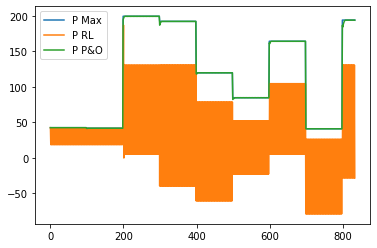

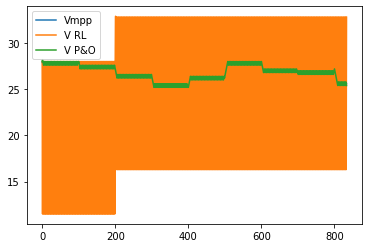

INFO 2020-11-21 22:40:23,798 PO Efficiency=99.87892064901877
INFO 2020-11-21 22:40:23,799 RL Efficiency=24.649759959983108


In [12]:
agent.exp_test_source.play_episode()
test_env.render_vs_true(po=True)

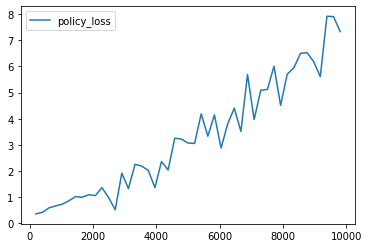

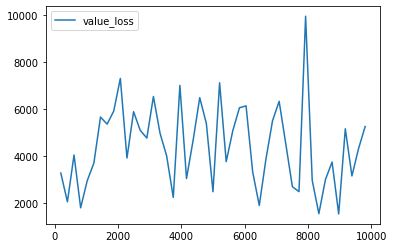

In [7]:
agent.plot_performance(['policy_loss', 'value_loss'])

In [8]:
agent.epsilon_tracker.value

0.01